# Primary Exploration

In this exploration experiment, I will look at the relationship between gross primary productivity and root moisture. We 

**Hypothesis**: These variables have are correlated spatially and change their correlation depending upon the time stamp chosen and the area.

In [43]:
import sys
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# from processing import PrelimAnalysis
from features.dependence import (DependenceExplore, 
                                 standardize_spatial, 
                                 standardize_temporal, 
                                 get_corr_spatial, 
                                 get_corr_temporal)

# from py_esdc.data import ESDCData
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df

from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We want the gpp and rm data for the years 2009, 2010 and 2011

In [47]:
start_year = '2007'
end_year = '2010'
years = ['2007', '2008', '2009', '2010']
variable1 = 'gross_primary_productivity'
variable2 = 'root_moisture'

ESDC_data = xr.merge([
    xr.open_mfdataset(
        '/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/*e.nc'),
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity/*.nc')]
)

ESDC_data = xr.merge([
    ESDC_data[variable1].sel(time=slice(start_year, end_year)),
    ESDC_data[variable2].sel(time=slice(start_year, end_year))
])


### SubAreas (Europe, Russia)

In this experiment, we are looking at the subareas of europe and Russia to make a comparison between the two areas. In theory, Russia should have some extraneous affects.

In [48]:
esdc_data_europe = ESDC_data.sel(lat=slice(70., 30.), lon=slice(-20., 35.))
esdc_data_russia = ESDC_data.sel(lat=slice(60., 50.), lon=slice(30., 60.))

## Visualize: Yearly Temporal Mean

We will plot the mean GPP and RM value for Europe and Russia respectively.

#### Gross Primary Productivity

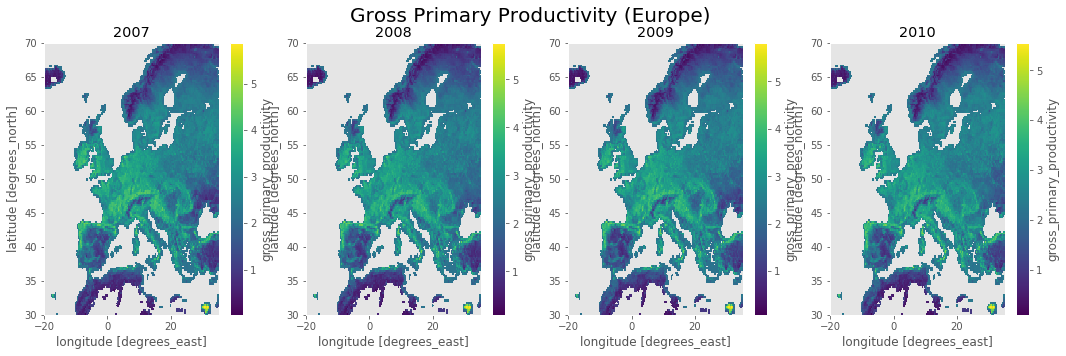

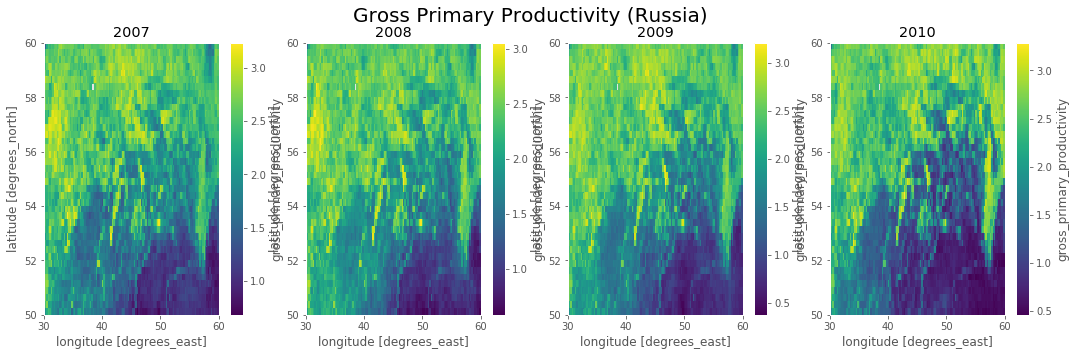

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 5))

for iteration, iyear in enumerate(years):
    subdata = esdc_data_europe[variable1]
    subdata.sel(time=slice(iyear, iyear)).mean(dim='time').plot.pcolormesh(ax=ax[iteration], cmap='viridis')
    ax[iteration].set_title(f'{iyear}')
    
fig.suptitle('Gross Primary Productivity (Europe)', fontsize=20)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 5))

for iteration, iyear in enumerate(years):
    subdata = esdc_data_russia[variable1]
    subdata.sel(time=slice(iyear, iyear)).mean(dim='time').plot.pcolormesh(ax=ax[iteration], cmap='viridis')
    ax[iteration].set_title(f'{iyear}')
    
fig.suptitle('Gross Primary Productivity (Russia)', fontsize=20)
plt.show()

#### Root Moisture

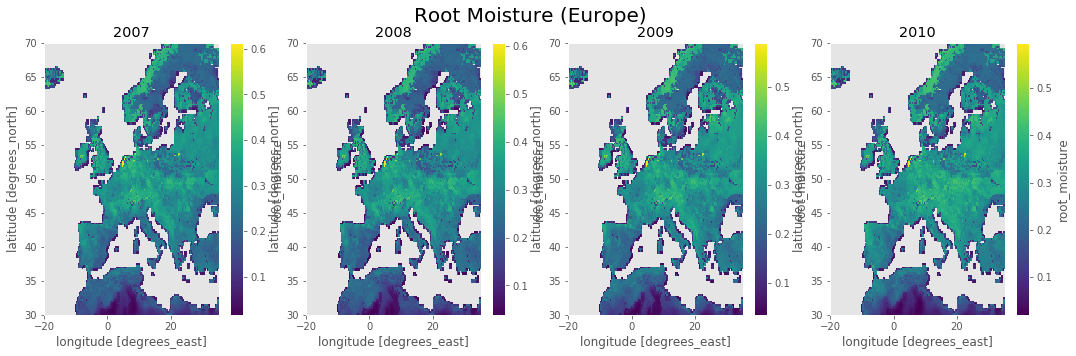

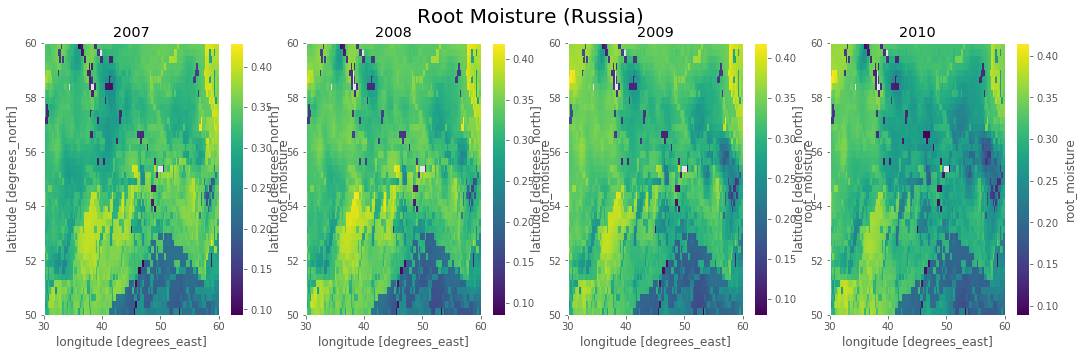

In [50]:
# EUROPE
fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 5))

for iteration, iyear in enumerate(years):
    subdata = esdc_data_europe[variable2]
    subdata.sel(time=slice(iyear, iyear)).mean(dim='time').plot.pcolormesh(ax=ax[iteration], cmap='viridis')
    ax[iteration].set_title(f'{iyear}')
    
fig.suptitle('Root Moisture (Europe)', fontsize=20)
plt.show()


# RUSSIA
fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 5))

for iteration, iyear in enumerate(years):
    subdata = esdc_data_russia[variable2]
    subdata.sel(time=slice(iyear, iyear)).mean(dim='time').plot.pcolormesh(ax=ax[iteration], cmap='viridis')
    
    ax[iteration].set_title(f'{iyear}')
    
fig.suptitle('Root Moisture (Russia)', fontsize=20)

plt.show()

## Visualize: Yearly Spatial Mean

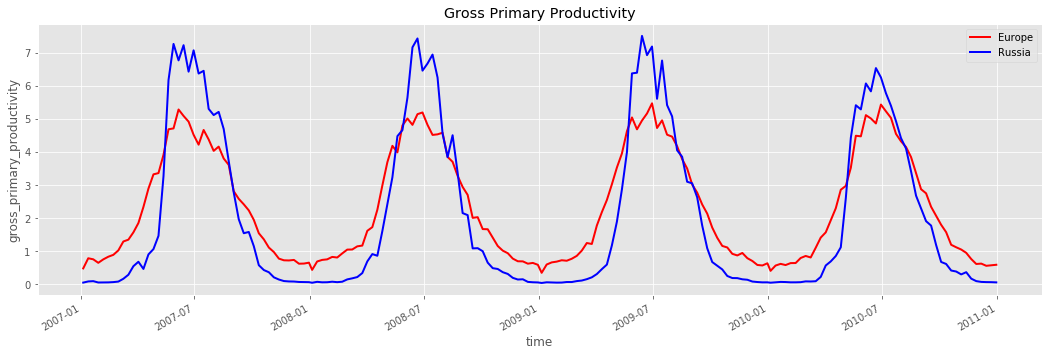

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
variable1 = 'gross_primary_productivity'

# Europe
sub_data = esdc_data_europe.groupby('time').mean(dim=['lat', 'lon'])
sub_data[variable1].plot(ax=ax, label='Europe', color='red', linewidth=2)

# Russia
sub_data = esdc_data_russia.groupby('time').mean(dim=['lat', 'lon'])
sub_data[variable1].plot(ax=ax, label='Russia', color='blue', linewidth=2)
ax.set_title('Gross Primary Productivity')
ax.legend()

plt.show()

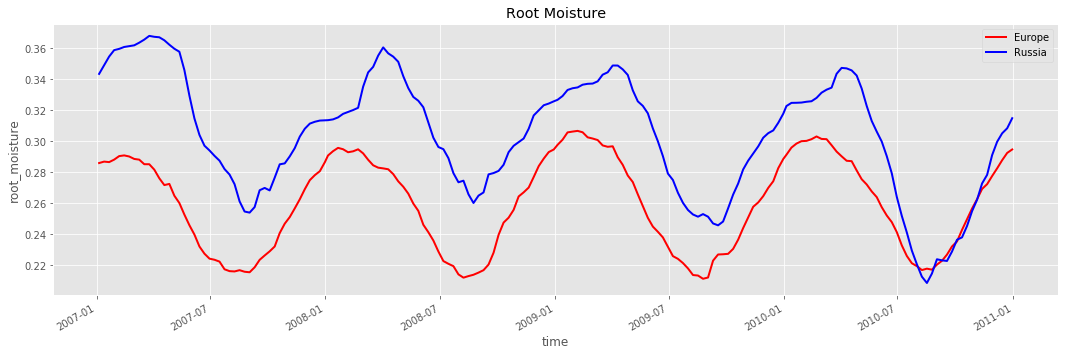

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
variable2 = 'root_moisture'

# Europe
sub_data = esdc_data_europe.groupby('time').mean(dim=['lat', 'lon'])
sub_data[variable2].plot(ax=ax, label='Europe', color='red', linewidth=2)

# Russia
sub_data = esdc_data_russia.groupby('time').mean(dim=['lat', 'lon'])
sub_data[variable2].plot(ax=ax, label='Russia', color='blue', linewidth=2)
ax.set_title('Root Moisture')
ax.legend()

plt.show()

## Compare Means (Time by Time)

In [57]:
gpp_means_europe = dict()
rm_means_europe = dict()
gpp_means_russia = dict()
rm_means_russia = dict()

In [60]:
def compare_spatial_means(X, Y):
    
    X = X.groupby('time').mean(dim=['lat', 'lon']).compute().data
    Y = Y.groupby('time').mean(dim=['lat', 'lon']).compute().data
    return np.array([X, Y])

In [62]:
%%time

# =======================
# EUROPE - GPP
# =======================
gpp_means_europe['2007_vs_2008'] = compare_spatial_means(
    esdc_data_europe[variable1].sel(time=slice('2007', '2007')),
    esdc_data_europe[variable1].sel(time=slice('2008', '2008'))
)

gpp_means_europe['2008_vs_2009'] = compare_spatial_means(
    esdc_data_europe[variable1].sel(time=slice('2008', '2008')),
    esdc_data_europe[variable1].sel(time=slice('2009', '2009'))
)

gpp_means_europe['2009_vs_2010'] = compare_spatial_means(
    esdc_data_europe[variable1].sel(time=slice('2009', '2009')),
    esdc_data_europe[variable1].sel(time=slice('2010', '2010'))
)

# =======================
# EUROPE - RM
# =======================
rm_means_europe['2007_vs_2008'] = compare_spatial_means(
    esdc_data_europe[variable2].sel(time=slice('2007', '2007')),
    esdc_data_europe[variable2].sel(time=slice('2008', '2008'))
)

rm_means_europe['2008_vs_2009'] = compare_spatial_means(
    esdc_data_europe[variable2].sel(time=slice('2008', '2008')),
    esdc_data_europe[variable2].sel(time=slice('2009', '2009'))
)

rm_means_europe['2009_vs_2010'] = compare_spatial_means(
    esdc_data_europe[variable2].sel(time=slice('2009', '2009')),
    esdc_data_europe[variable2].sel(time=slice('2010', '2010'))
)


# =======================
# RUSSIA - GPP
# =======================
gpp_means_russia['2007_vs_2008'] = compare_spatial_means(
    esdc_data_russia[variable1].sel(time=slice('2007', '2007')),
    esdc_data_russia[variable1].sel(time=slice('2008', '2008'))
)

gpp_means_russia['2008_vs_2009'] = compare_spatial_means(
    esdc_data_russia[variable1].sel(time=slice('2008', '2008')),
    esdc_data_russia[variable1].sel(time=slice('2009', '2009'))
)

gpp_means_russia['2009_vs_2010'] = compare_spatial_means(
    esdc_data_russia[variable1].sel(time=slice('2009', '2009')),
    esdc_data_russia[variable1].sel(time=slice('2010', '2010'))
)

# =======================
# RUSSIA - RM
# =======================
rm_means_russia['2007_vs_2008'] = compare_spatial_means(
    esdc_data_russia[variable2].sel(time=slice('2007', '2007')),
    esdc_data_russia[variable2].sel(time=slice('2008', '2008'))
)

rm_means_russia['2008_vs_2009'] = compare_spatial_means(
    esdc_data_russia[variable2].sel(time=slice('2008', '2008')),
    esdc_data_russia[variable2].sel(time=slice('2009', '2009'))
)

rm_means_russia['2009_vs_2010'] = compare_spatial_means(
    esdc_data_russia[variable2].sel(time=slice('2009', '2009')),
    esdc_data_russia[variable2].sel(time=slice('2010', '2010'))
)

CPU times: user 8.54 s, sys: 1min 19s, total: 1min 27s
Wall time: 2.99 s


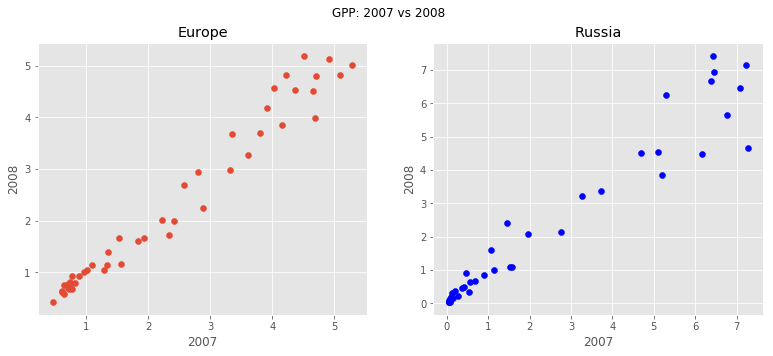

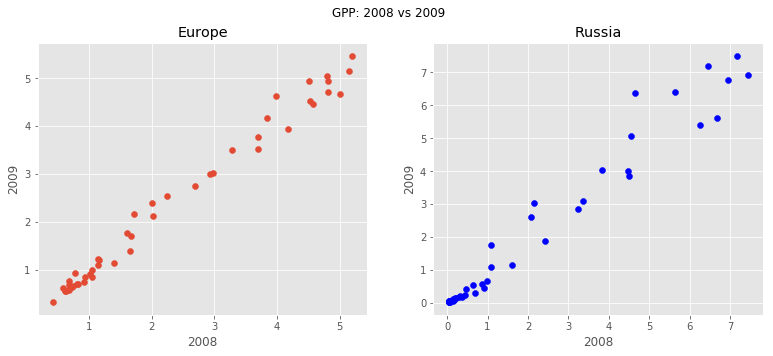

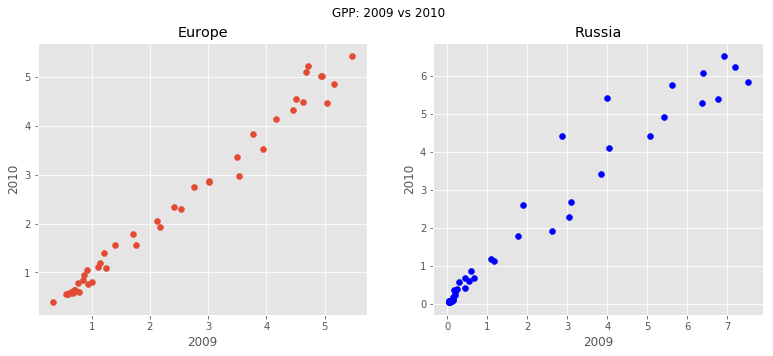

In [63]:
# 2007 vs 2008
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle('GPP: 2007 vs 2008')

ax[0].scatter(gpp_means_europe['2007_vs_2008'][0, :],
              gpp_means_europe['2007_vs_2008'][1, :])
ax[0].set_title('Europe')
ax[0].set_xlabel('2007')
ax[0].set_ylabel('2008')

ax[1].scatter(gpp_means_russia['2007_vs_2008'][0, :],
              gpp_means_russia['2007_vs_2008'][1, :], color='blue')
ax[1].set_title('Russia')
ax[1].set_xlabel('2007')
ax[1].set_ylabel('2008')
# ax[1].set_ylim([-.5, 8])
plt.show()

# 2009 vs 2010
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle('GPP: 2008 vs 2009')

ax[0].scatter(gpp_means_europe['2008_vs_2009'][0, :],
              gpp_means_europe['2008_vs_2009'][1, :])
ax[0].set_title('Europe')
ax[0].set_xlabel('2008')
ax[0].set_ylabel('2009')

ax[1].scatter(gpp_means_russia['2008_vs_2009'][0, :],
              gpp_means_russia['2008_vs_2009'][1, :], color='blue')
ax[1].set_title('Russia')
ax[1].set_xlabel('2008')
ax[1].set_ylabel('2009')
# ax[1].set_ylim([-.5, 8])
plt.show()

# 2009 vs 2011
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle('GPP: 2009 vs 2010')

ax[0].scatter(gpp_means_europe['2009_vs_2010'][0, :],
              gpp_means_europe['2009_vs_2010'][1, :])
ax[0].set_title('Europe')
ax[0].set_xlabel('2009')
ax[0].set_ylabel('2010')

ax[1].scatter(gpp_means_russia['2009_vs_2010'][0, :],
              gpp_means_russia['2009_vs_2010'][1, :], color='blue')
ax[1].set_title('Russia')
ax[1].set_xlabel('2009')
ax[1].set_ylabel('2010')
# ax[1].set_ylim([-.5, 8])

plt.show()


## Pearson Correlation Coefficient

In [64]:
def pearson_corr_coeff(X, Y):
    
    # Get Mean
    X_mean = X.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    Y_mean = Y.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    
    # Calculate Covariance
    cov = (X - X_mean) * (Y - Y_mean)
    
    # Get STD
    X_std = X.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    Y_std = Y.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    
    # Get Correlation Coefficient
    corr_coef = cov / (X_std * Y_std)
    
    # Get mean of coordinates
    corr_coef = corr_coef.mean(dim=['lat', 'lon'], skipna=True).compute()
    
    return corr_coef

In [65]:
pearsons_europe = dict()
pearsons_russia = dict()

In [77]:
%%time

# =======================
# 2007
# =======================
pearsons_europe['2007'] = pearson_corr_coeff(
    esdc_data_europe[variable1].sel(time=slice('2007', '2007')),
    esdc_data_europe[variable2].sel(time=slice('2007', '2007'))
)

pearsons_russia['2007'] = pearson_corr_coeff(
    esdc_data_russia[variable1].sel(time=slice('2007', '2007')),
    esdc_data_russia[variable2].sel(time=slice('2007', '2007'))
)

# =======================
# 2008
# =======================
pearsons_europe['2008'] = pearson_corr_coeff(
    esdc_data_europe[variable1].sel(time=slice('2008', '2008')),
    esdc_data_europe[variable2].sel(time=slice('2008', '2008'))
)

pearsons_russia['2008'] = pearson_corr_coeff(
    esdc_data_russia[variable1].sel(time=slice('2008', '2008')),
    esdc_data_russia[variable2].sel(time=slice('2008', '2008'))
)

# =======================
# 2009
# =======================
pearsons_europe['2009'] = pearson_corr_coeff(
    esdc_data_europe[variable1].sel(time=slice('2009', '2009')),
    esdc_data_europe[variable2].sel(time=slice('2009', '2009'))
)

pearsons_russia['2009'] = pearson_corr_coeff(
    esdc_data_russia[variable1].sel(time=slice('2009', '2009')),
    esdc_data_russia[variable2].sel(time=slice('2009', '2009'))
)

# =======================
# 2010
# =======================
pearsons_europe['2010'] = pearson_corr_coeff(
    esdc_data_europe[variable1].sel(time=slice('2010', '2010')),
    esdc_data_europe[variable2].sel(time=slice('2010', '2010'))
)

pearsons_russia['2010'] = pearson_corr_coeff(
    esdc_data_russia[variable1].sel(time=slice('2010', '2010')),
    esdc_data_russia[variable2].sel(time=slice('2010', '2010'))
)

CPU times: user 9.24 s, sys: 57.3 s, total: 1min 6s
Wall time: 5.17 s


In [78]:
pearsons_europe = xr.concat([
    pearsons_europe['2007'],
    pearsons_europe['2008'],
    pearsons_europe['2009'],
    pearsons_europe['2010']
], dim='time')

In [79]:
pearsons_russia = xr.concat([
    pearsons_russia['2007'],
    pearsons_russia['2008'],
    pearsons_russia['2009'],
    pearsons_russia['2010']
], dim='time')

In [80]:
pearsons_europe

<xarray.DataArray '2007' (time: 736)>
array([-0.288925, -0.255321, -0.282537, ..., -0.341822, -0.325111, -0.300372],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-05 2007-01-13 ... 2010-12-31
    2007     (time) float32 -0.28892452 -0.2553213 -0.28253675 ... nan nan nan
    2008     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    2009     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    2010     (time) float32 nan nan nan ... -0.34182245 -0.32511133 -0.3003717

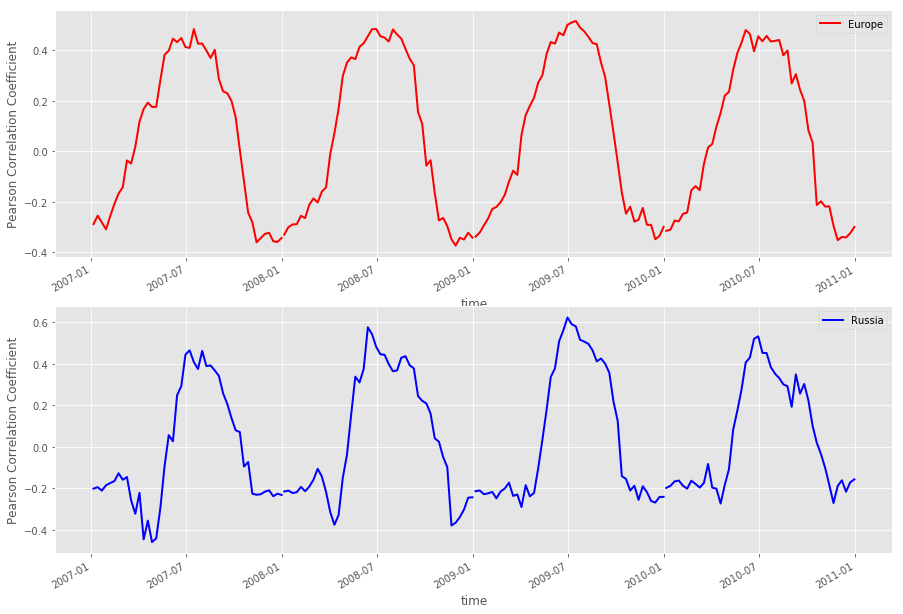

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

pearsons_europe.plot(ax=ax[0], label='Europe', color='red', linewidth=2)
pearsons_russia.plot(ax=ax[1], label='Russia', color='blue', linewidth=2)

ax[0].legend()
ax[0].set_ylabel('Pearson Correlation Coefficient')
ax[1].legend()
ax[1].set_ylabel('Pearson Correlation Coefficient')
plt.show()

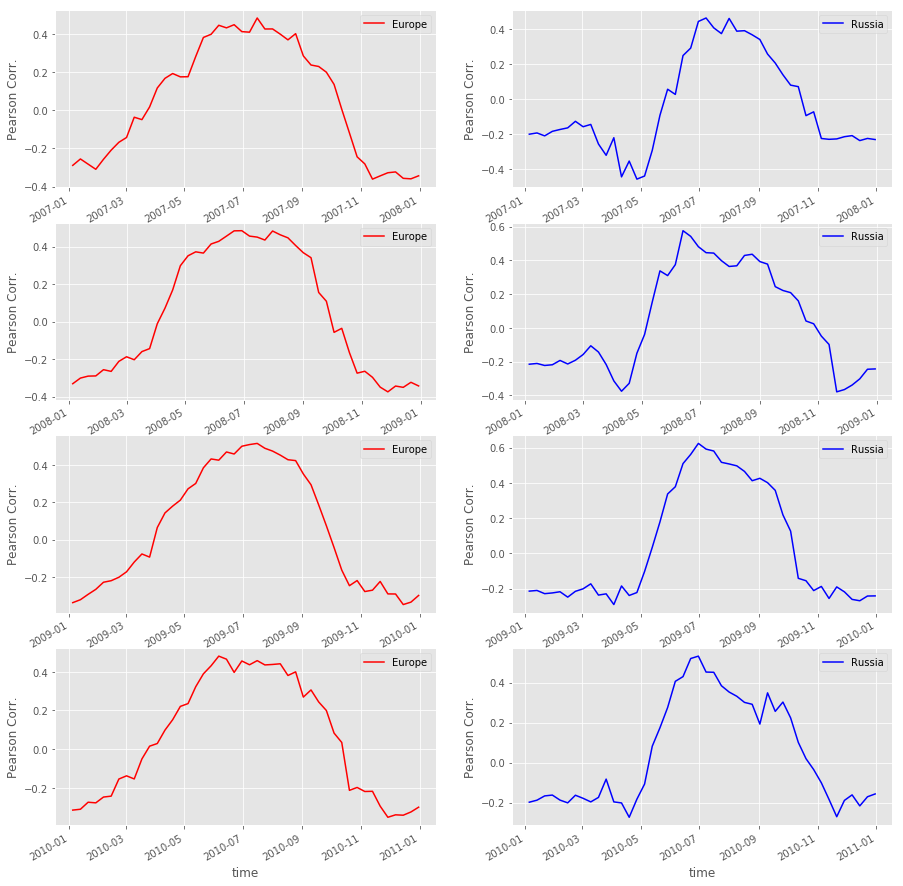

In [69]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
years = [ikey for ikey in pearsons_europe.keys()]
for iyear, iax in zip(years, ax):
    pearsons_europe[iyear].plot(ax=iax[0], label='Europe', color='red')
    iax[0].set_ylabel('Pearson Corr.')
    iax[0].legend()

    pearsons_russia[iyear].plot(ax=iax[1], label='Russia', color='blue')
    iax[1].set_ylabel('Pearson Corr.')
    iax[1].legend()


plt.show()

### Spatial Correlation

In [ ]:
def corr_coeff(variable1_name, variable2_name):
    variable1 = country_cube_array.sel(Indicator_Codes = variable1_name)
    variable2 = country_cube_array.sel(Indicator_Codes = variable2_name)
    cov = _get_covariance(variable1, variable2)
    variable1_std = variable1.std(dim="Year")
    variable2_std = variable2.std(dim="Year")
    return _get_corr_coeff(cov, variable1_std, variable2_std)

def _get_covariance(variable1_array, variable2_array):
    X = (variable1_array - variable1_array.mean(dim="Year", skipna=True))
    Y = (variable2_array - variable2_array.mean(dim="Year", skipna=True))
    xxyy = X * Y
    return xxyy.mean(dim="Year")

def _get_corr_coeff(cov, std1, std2):
    return cov / (std1 * std2)

In [41]:
def spatial_correlation(X, Y):
    
    # Get Mean
    X_mean = X.mean(dim=['lat', 'lon'], skipna=None)
    Y_mean = Y.mean(dim=['lat', 'lon'], skipna=None)
    
    # Subtract Mean
    
    # Get Standard Deviation
    X_std = X.std(dim=['lat', 'lon'], skipna=None)
    Y_std = Y.std(dim=['lat', 'lon'], skipna=None)
    return

In [40]:
# Get Time Stamps
times = esdc_data_europe.sel(time=slice('2010', '2010')).time.data


for itime in times:
    
    # Compare 2009, 2010
    
    
    # Compare 2010, 2011
    
    
    # Compare 2009, 2011
    

['2010-01-05T00:00:00.000000000' '2010-01-13T00:00:00.000000000'
 '2010-01-21T00:00:00.000000000' '2010-01-29T00:00:00.000000000'
 '2010-02-06T00:00:00.000000000' '2010-02-14T00:00:00.000000000'
 '2010-02-22T00:00:00.000000000' '2010-03-02T00:00:00.000000000'
 '2010-03-10T00:00:00.000000000' '2010-03-18T00:00:00.000000000'
 '2010-03-26T00:00:00.000000000' '2010-04-03T00:00:00.000000000'
 '2010-04-11T00:00:00.000000000' '2010-04-19T00:00:00.000000000'
 '2010-04-27T00:00:00.000000000' '2010-05-05T00:00:00.000000000'
 '2010-05-13T00:00:00.000000000' '2010-05-21T00:00:00.000000000'
 '2010-05-29T00:00:00.000000000' '2010-06-06T00:00:00.000000000'
 '2010-06-14T00:00:00.000000000' '2010-06-22T00:00:00.000000000'
 '2010-06-30T00:00:00.000000000' '2010-07-08T00:00:00.000000000'
 '2010-07-16T00:00:00.000000000' '2010-07-24T00:00:00.000000000'
 '2010-08-01T00:00:00.000000000' '2010-08-09T00:00:00.000000000'
 '2010-08-17T00:00:00.000000000' '2010-08-25T00:00:00.000000000'
 '2010-09-02T00:00:00.000

## Standardization

## Climatology

In [146]:
esdc_data = DependenceExplore()

year = '2010'
data = esdc_data.get_xr_data(year=year)
data_europe = esdc_data.get_subarea(data, area='europe')


data_russia = esdc_data.get_subarea(data, area='russia')

### Visualize: Yearly Mean

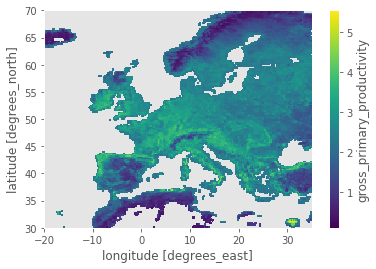

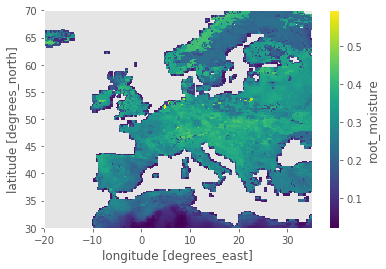

In [147]:
esdc_data.plot_yearly_mean(data_europe.gross_primary_productivity, 'gpp_europe')
esdc_data.plot_yearly_mean(data_europe.root_moisture, 'rm_europe')

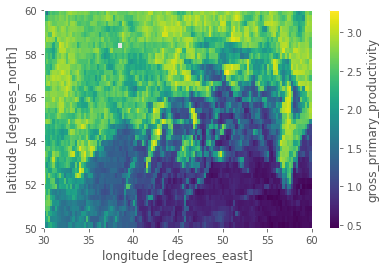

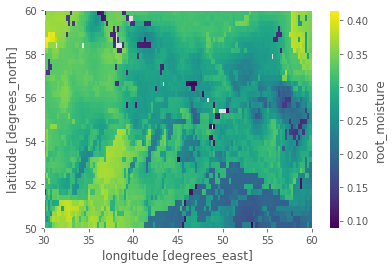

In [149]:
esdc_data.plot_yearly_mean(data_russia.gross_primary_productivity, 'gpp_russia')
esdc_data.plot_yearly_mean(data_russia.root_moisture, 'rm_russia')

### Monthly Stats

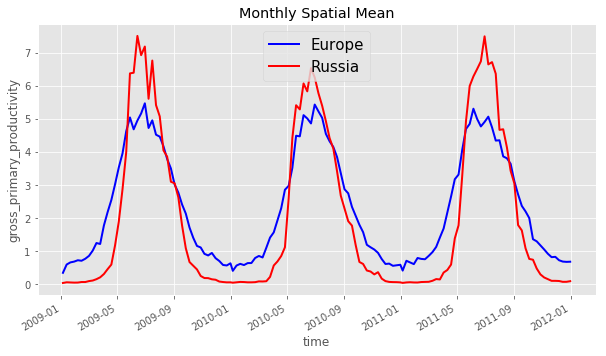

In [178]:
years = ['2009', '2010', '2011']
datasets_europe = list()
datasets_russia = list()
for iyear in years:
    esdc_data = DependenceExplore()

    data = esdc_data.get_xr_data(year=iyear)
    datasets_europe.append(esdc_data.get_subarea(data, area='europe'))


    datasets_russia.append(esdc_data.get_subarea(data, area='russia'))
    
data_europe = xr.concat(datasets_europe, dim='time')
data_russia = xr.concat(datasets_russia, dim='time')
esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='mean', 
    save_name=f'monthly_gpp_{iyear}')

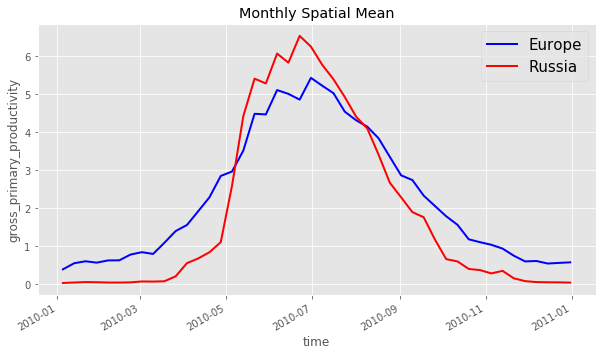

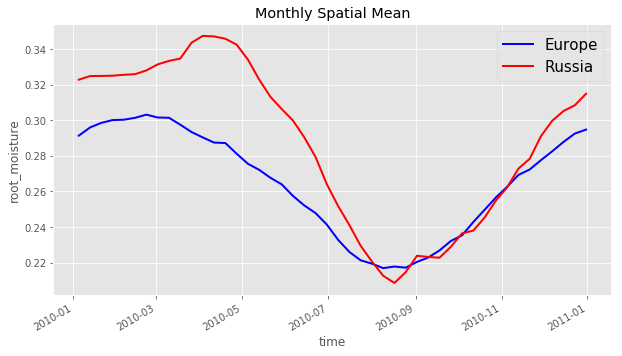

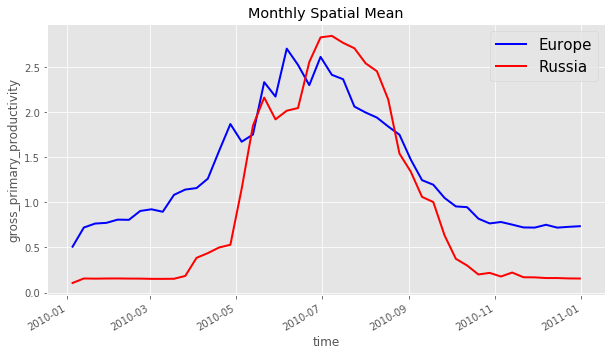

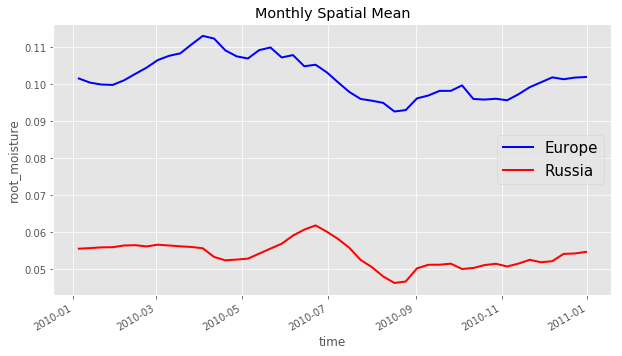

In [158]:
esdc_data = DependenceExplore()

year = '2010'
data = esdc_data.get_xr_data(year=year)
data_europe = esdc_data.get_subarea(data, area='europe')


data_russia = esdc_data.get_subarea(data, area='russia')

esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='mean', 
    save_name='monthly_gpp')

esdc_data.plot_monthly(
    data_europe.root_moisture,
    data_russia.root_moisture, 
    stat='mean', 
    save_name='monthly_rm')

esdc_data.plot_monthly(
    data_europe.gross_primary_productivity,
    data_russia.gross_primary_productivity, 
    stat='std', 
    save_name='monthly_gpp')

esdc_data.plot_monthly(
    data_europe.root_moisture,
    data_russia.root_moisture, 
    stat='std', 
    save_name='monthly_rm')

### Standardization

In [164]:
data_europe_st = standardize_spatial(data_europe)
data_russia_st = standardize_spatial(data_russia)

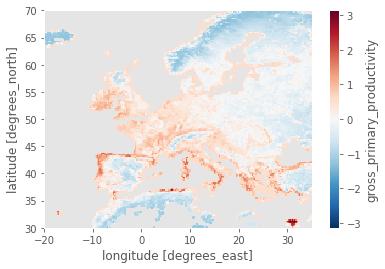

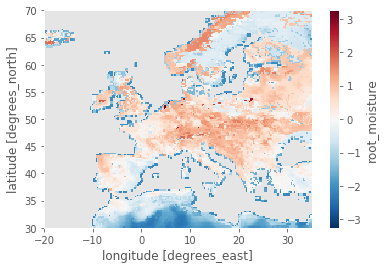

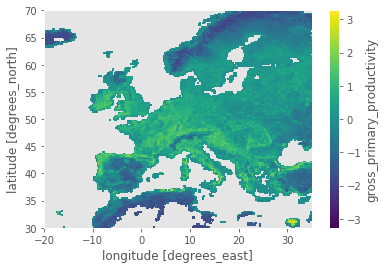

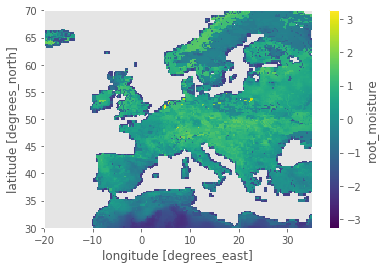

### Correlation

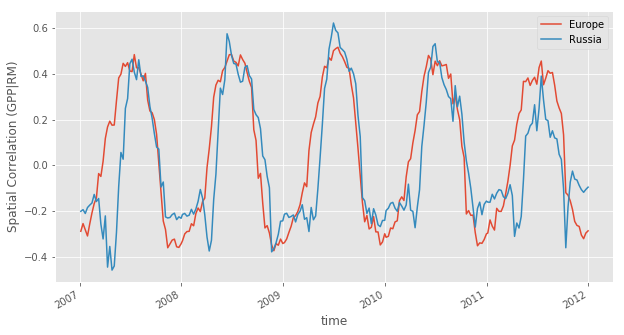

Text(0, 0.5, 'Spatial Correlation (GPP|RM)')

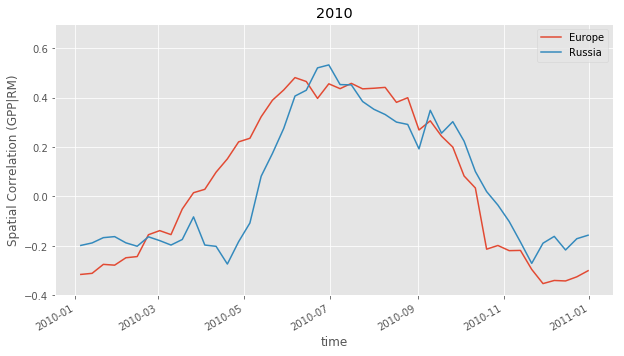

Text(0, 0.5, 'Temporal Correlation (GPP|RM)')

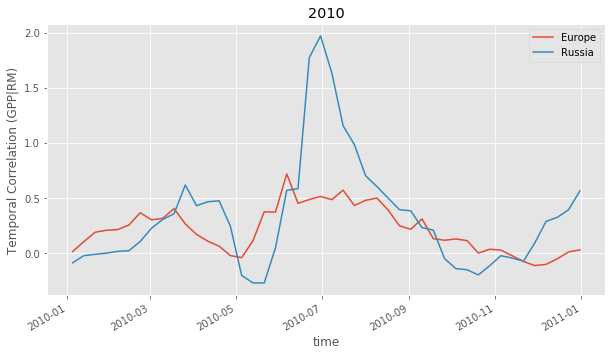

In [121]:
# Get Spatial Correlation
corr_europe = get_corr_temporal(gpp_europe_st, rm_europe_st)
corr_russia = get_corr_temporal(gpp_russia_st, rm_russia_st)

# ymax = np.max(corr_europe.max().compute(), corr_russia.max().compute())
fig, ax = plt.subplots(figsize=(10, 5))

corr_europe.plot(ax=ax, label='Europe')
corr_russia.plot(ax=ax, label='Russia')
# ax.set_ylim([-0.4, ymax])
ax.legend()
ax.set_title('2010')
ax.set_ylabel('Temporal Correlation (GPP|RM)')

ValueError: must supply at least one object to concatenate

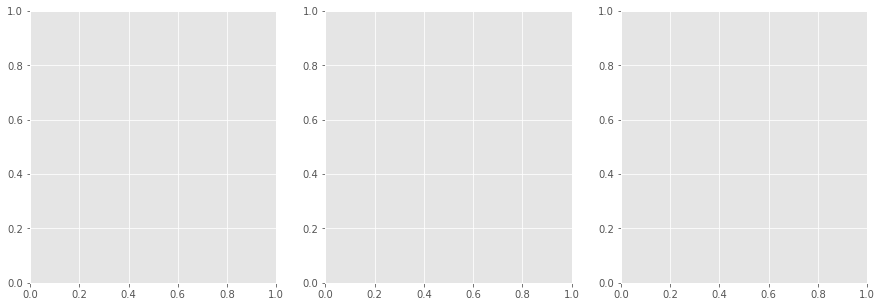

In [108]:
years = ['2009'] #, '2010', '2011']

fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

for iyear, ax in zip(years, axs):
    
    # Extract for Europe
    gpp_sub = gpp_europe_st.sel(time=slice(iyear, iyear))
    rm_sub = rm_europe_st.sel(time=slice(iyear, iyear))
    corr_europe = get_corr_spatial(gpp_sub, rm_sub)
    
    # Extract for Russia
    gpp_sub_r = gpp_russian_st.sel(time=slice(iyear, iyear))
    rm_sub_r = rm_russian_st.sel(time=slice(iyear, iyear))
    corr_russia = get_corr_spatial(gpp_sub_r, rm_sub_r)

    corr_europe.plot(ax=ax, label='Europe')
    corr_russia.plot(ax=ax, label='Russia')
    ax.set_ylim([-0.4, 0.7])
    ax.legend()
    ax.set_title(iyear)
    ax.set_ylabel('Correlation (GPP|RM)')
    
plt.show()
fig.savefig(figure_path + f"corr_{iyear}.png")

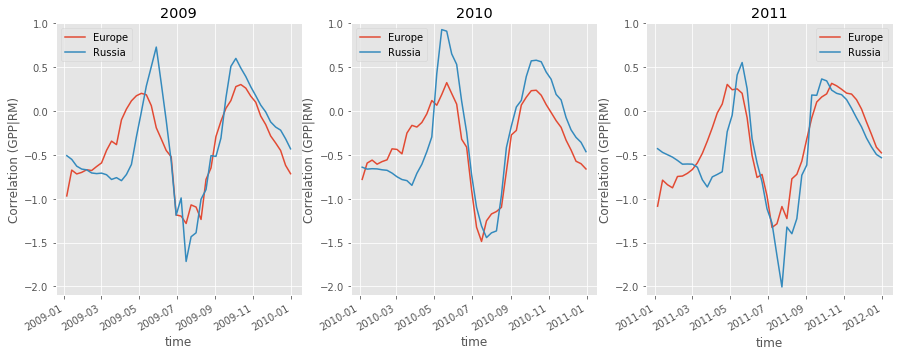

In [19]:
years = ['2009', '2010', '2011']
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
for iyear, ax in zip(years, axs):
    # Extract for Europe
    gpp_sub = gpp_europe.sel(time=slice(iyear, iyear))
    rm_sub = rm_europe.sel(time=slice(iyear, iyear))
    corr_europe = get_corr_temporal(gpp_sub, rm_sub)
#     print(corr_europe)
#     print(corr_europe.max().compute(), corr_europe.min().compute())
    # Extract for Europe
    gpp_sub_r = gpp_russian.sel(time=slice(iyear, iyear))
    rm_sub_r = rm_russian.sel(time=slice(iyear, iyear))
    corr_russia = get_corr_temporal(gpp_sub_r, rm_sub_r)

    corr_europe.plot(ax=ax, label='Europe')
    corr_russia.plot(ax=ax, label='Russia')
    ax.legend()
    ax.set_ylim([-2.1, 1.0])
    ax.set_title(iyear)
    ax.set_ylabel('Correlation (GPP|RM)')
plt.show()
fig.savefig(figure_path + f"corr_temporal_{iyear}.png")